## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

## Helper Functions

## Pure Random

In [2]:
def generate_random_spike_data(width=16, length_ms=120000, average_rate=0.5):
    """
    Generate spike times for neurons arranged in a width x width grid.
    
    Parameters:
    - width: The width of the square grid.
    - length_ms: The recording length in milliseconds.
    - average_rate: The average firing rate in Hz.
    
    Returns:
    A SpikeData object containing spike times and neuron positions.
    """
    np.random.seed(0)
    N_channels = width * width
    train = []

    # Generate spike times
    for _ in range(N_channels):
        num_spikes = np.random.poisson(average_rate * length_ms / 1000)
        spike_times = np.random.uniform(0, length_ms, num_spikes)
        train.append(spike_times)

    # Generate positions for each neuron (channel) in a width x width grid
    positions = [(x, y) for x in range(width) for y in range(width)]

    # Initialize neuron_data with positions
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Create and return SpikeData object
    spike_data = SpikeData(train, neuron_data=neuron_data)
    return spike_data

## Linear Propagation

### Basic

In [18]:
def generate_overlap_spike_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms, target_firing_rate_hz):
    N_channels = rows * cols
    # Calculate adjusted segment and total durations
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations
    
    # Calculate spikes per segment per channel to match the target firing rate
    total_spikes_per_channel = (total_duration_ms / 1000) * target_firing_rate_hz
    spikes_per_segment = total_spikes_per_channel / num_propagations
    
    # Initialize neuron positions and data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    
    # Initialize spike train
    train_patterned_overlap = [[] for _ in range(N_channels)]
    
    # Generate spike times with specified overlap, breaks, and target firing rate
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)
        
        for row in range(rows):
            row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
            spike_time_start = row_start
            spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms
            
            for col in range(cols):
                channel_index = row * cols + col
                # Adjust the number of points generated by np.linspace to control the firing rate
                spike_times = np.linspace(spike_time_start, spike_time_end, int(spikes_per_segment))
                train_patterned_overlap[channel_index].extend(spike_times)
    
    # Convert lists to numpy arrays for efficiency
    train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]
    
    # Create the SpikeData object for the new dataset
    spike_data_patterned_overlap = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)
    
    return spike_data_patterned_overlap

### With Randomization

In [36]:
def generate_random_overlap_spike_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms, target_firing_rate_hz):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations

    # Calculate total spikes needed per channel to match the target firing rate
    total_duration_s = total_duration_ms / 1000.0
    total_spikes_needed = int(total_duration_s * target_firing_rate_hz * N_channels)

    # Initialize neuron positions and data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Initialize spike trains with empty lists for each channel
    train_patterned_overlap = [[] for _ in range(N_channels)]
    
    # Pre-assign at least one firing event for each neuron across the propagations
    preassigned_firings = {neuron_index: random.randint(0, num_propagations - 1) for neuron_index in range(N_channels)}

    # Generate spike times with specified overlap, breaks, and random firing
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)

        for row in range(rows):
            row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
            spike_time_start = row_start
            spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms

            # Randomly decide which neurons in the row will fire (random proportion)
            firing_neurons_in_row = random.sample(range(row * cols, (row + 1) * cols), random.randint(1, cols))

            # Ensure pre-assigned neurons for this propagation are included
            for neuron_index in range(row * cols, (row + 1) * cols):
                if preassigned_firings[neuron_index] == propagation and neuron_index not in firing_neurons_in_row:
                    firing_neurons_in_row.append(neuron_index)

            # Adjust the number of spikes based on target firing rate
            spikes_per_firing_event = max(1, int((total_spikes_needed / num_propagations) / len(firing_neurons_in_row)))

            for neuron_index in firing_neurons_in_row:
                spike_times = np.linspace(spike_time_start, spike_time_end, spikes_per_firing_event)
                train_patterned_overlap[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays for efficiency
    train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]

    # Create the SpikeData object with the new dataset
    spike_data_patterned_random_firing = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_patterned_random_firing

## Circle Propagation

### Basic

In [50]:
def generate_overlap_circle_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms, target_firing_rate_hz):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations

    # Calculate total spikes needed to achieve the target firing rate
    total_duration_s = total_duration_ms / 1000.0
    total_spikes_needed = int(total_duration_s * target_firing_rate_hz * N_channels)
    spikes_per_channel = total_spikes_needed / N_channels

    center_x, center_y = (rows - 1) / 2, (cols - 1) / 2
    max_distance = np.sqrt((center_x) ** 2 + (center_y) ** 2)

    # Initialize positions, neuron data, and distances
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    distances = [np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) for x, y in positions]

    # Initialize spike trains with empty lists for each channel
    train_patterned_circle = [[] for _ in range(N_channels)]

    # Generate spike times based on neuron distance from center and target firing rate
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)
        for neuron_index, distance in enumerate(distances):
            firing_time_within_segment = (distance / max_distance) * (segment_duration_ms - overlap_duration_ms)
            spike_time_start = segment_start + firing_time_within_segment
            spike_time_end = spike_time_start + overlap_duration_ms
            # Adjust the number of spikes generated to control the firing rate
            spike_times = np.linspace(spike_time_start, spike_time_end, int(spikes_per_channel / num_propagations))

            train_patterned_circle[neuron_index].extend(spike_times)

    # Convert lists to numpy arrays for efficiency
    train_patterned_circle = [np.array(times) for times in train_patterned_circle]

    # Create the SpikeData object with the new dataset
    spike_data_patterned_circle = SpikeData(train=train_patterned_circle, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_patterned_circle

### With Randomization

In [51]:
def generate_random_overlap_circle_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms, target_firing_rate_hz):
    N_channels = rows * cols
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations

    total_duration_s = total_duration_ms / 1000.0
    total_spikes_needed = int(total_duration_s * target_firing_rate_hz * N_channels)
    spikes_per_channel = total_spikes_needed / N_channels

    center_x, center_y = (rows - 1) / 2, (cols - 1) / 2
    max_distance = np.sqrt((center_x) ** 2 + (center_y) ** 2)

    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    distances = [np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) for x, y in positions]

    train_patterned_circle = [[] for _ in range(N_channels)]
    
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)
        segment_end = segment_start + segment_duration_ms
        for neuron_index, distance in enumerate(distances):
            normalized_distance = distance / max_distance
            firing_time_start = segment_start + (normalized_distance * (segment_duration_ms - overlap_duration_ms)) - overlap_duration_ms / 2
            firing_time_end = firing_time_start + overlap_duration_ms

            firing_time_start = max(firing_time_start, segment_start)
            firing_time_end = min(firing_time_end, segment_end)

            if random.random() < 0.5:  # Random firing condition
                if firing_time_start < firing_time_end:
                    # Adjust spike_times generation based on target firing rate
                    spike_times = np.linspace(firing_time_start, firing_time_end, num=int(spikes_per_channel / num_propagations))
                    train_patterned_circle[neuron_index].extend(spike_times)

    train_patterned_circle = [np.array(times) for times in train_patterned_circle]

    spike_data_patterned_circle = SpikeData(train=train_patterned_circle, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)

    return spike_data_patterned_circle

## GENERATION

In [9]:
random_sd = generate_random_spike_data()

In [45]:
basic_linear_pattern = generate_overlap_spike_data(
    total_duration_ms=60000,
    num_propagations=5,
    rows=16,
    cols=16,
    overlap_duration_ms=100,
    break_duration_ms=5000,
    target_firing_rate_hz=10)

random_linear_pattern = generate_random_overlap_spike_data(
    total_duration_ms=60000,
    num_propagations=5,
    rows=16,
    cols=16,
    overlap_duration_ms=100,
    break_duration_ms=5000,
    target_firing_rate_hz=1)


In [56]:
basic_circular_pattern = generate_overlap_circle_data(
    total_duration_ms=60000,
    num_propagations=5,
    rows=16,
    cols=16,
    overlap_duration_ms=500,
    break_duration_ms=5000,
    target_firing_rate_hz=10)

random_circular_pattern = generate_random_overlap_circle_data(
    total_duration_ms=60000,
    num_propagations=5,
    rows=16,
    cols=16,
    overlap_duration_ms=100,
    break_duration_ms=5000,
    target_firing_rate_hz=10)



## PLOTTING

In [53]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def plot_raster(sd, title):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title(title)
    plt.show()

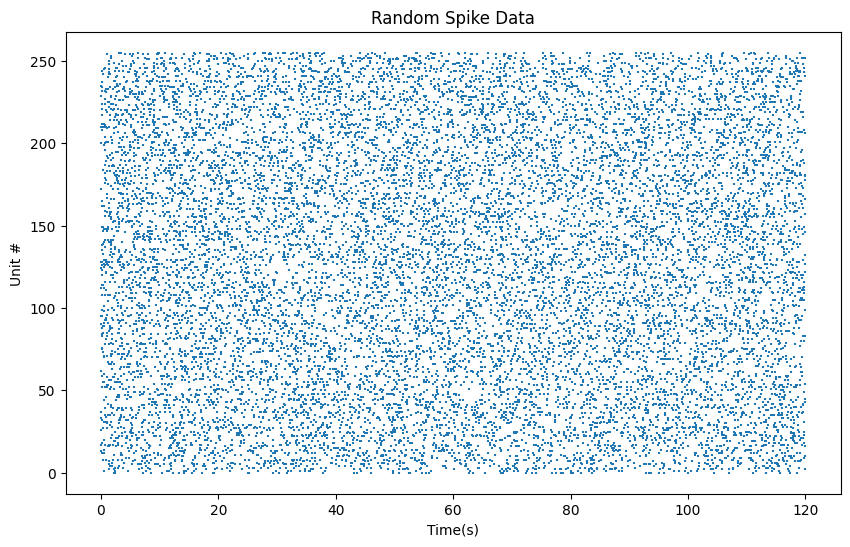

In [39]:
plot_raster(random_sd, "Random Spike Data")

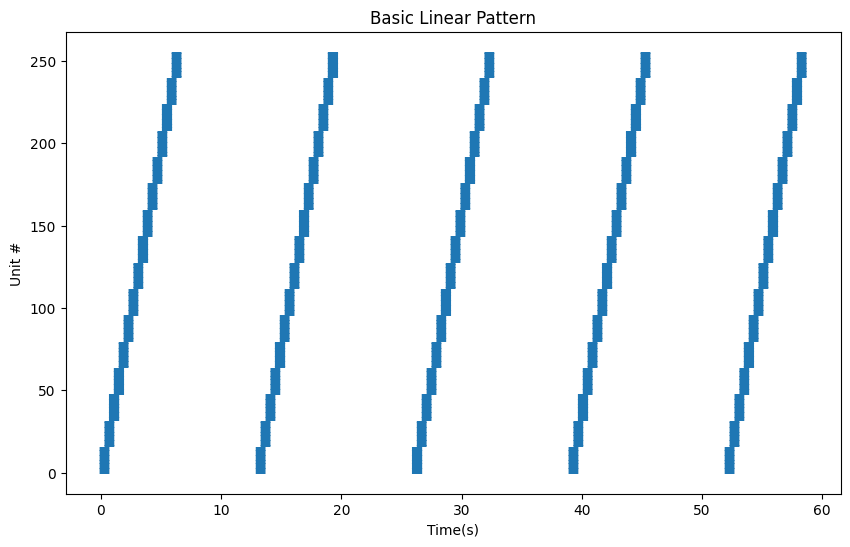

In [43]:
plot_raster(basic_linear_pattern, "Basic Linear Pattern")

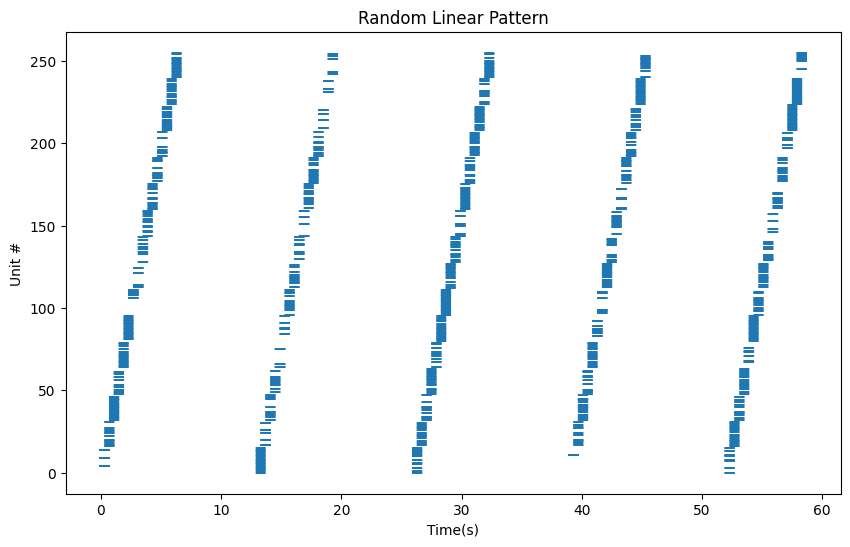

In [46]:
plot_raster(random_linear_pattern, "Random Linear Pattern")

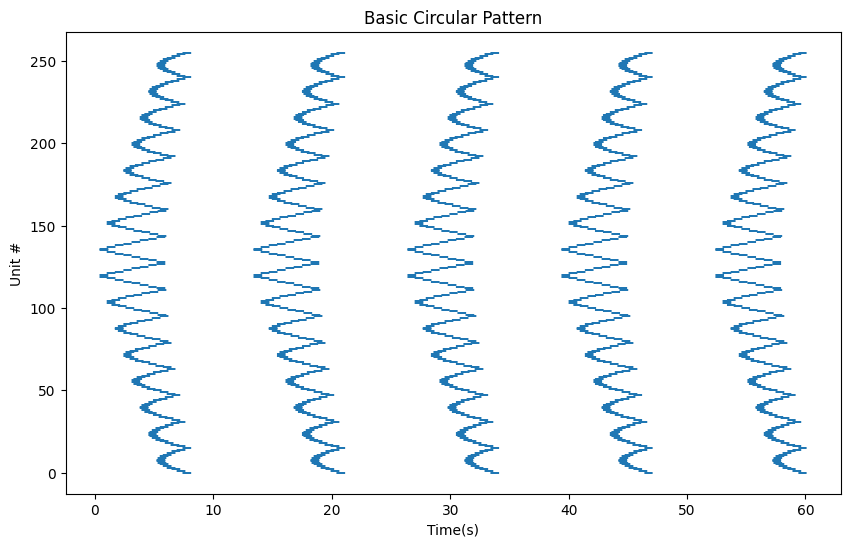

In [57]:
plot_raster(basic_circular_pattern, "Basic Circular Pattern")

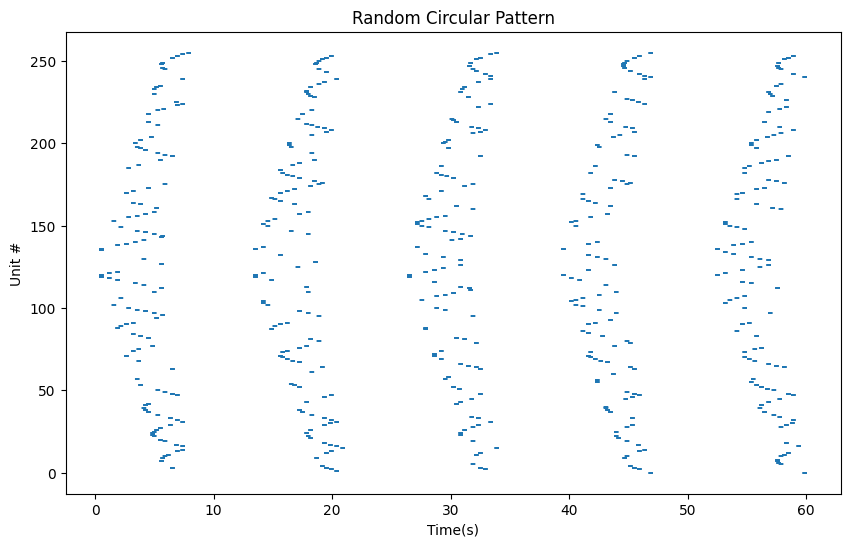

In [55]:
plot_raster(random_circular_pattern, "Random Circular Pattern")

## ANIMATOR

In [58]:
def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Synthetic Wave-Propagation Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

def create_animation(sd, frames_per_second, output_dir='firing_maps', animation_file='firing_animation.gif'):
    base_path = "/workspaces/human_hippocampus/dev/other/thomas/dissertation/saved_plots/animations"
    full_output_dir = os.path.join(base_path, output_dir)
    
    if not os.path.exists(full_output_dir):
        os.makedirs(full_output_dir)

    filenames = []
    
    # Adjust as necessary to capture the correct time segment
    # sd_test = sd.subtime(0, 10000)
    sd_test = sd
    total_recording_time_ms = sd_test.length  # Total recording time in milliseconds
    total_recording_time_s = total_recording_time_ms / 1000.0  # Convert ms to seconds

    # Calculate the total number of frames for the entire recording
    total_frames = int(frames_per_second * total_recording_time_s)
    
    # Calculate the global minimum and maximum firing rates for consistent coloring
    g_min_rate = np.min(calculate_mean_firing_rates(sd))
    g_max_rate = np.max(calculate_mean_firing_rates(sd))

    images = []
    for frame_number in range(total_frames):
        start_time_ms = (frame_number / frames_per_second) * 1000
        end_time_ms = ((frame_number + 1) / frames_per_second) * 1000
        sd_timestep = sd_test.subtime(start_time_ms, end_time_ms)
        
        firing_plotter(sd_timestep, global_min_rate=g_min_rate, global_max_rate=g_max_rate)
        
        filename = os.path.join(full_output_dir, f"frame_{frame_number}.png")
        plt.savefig(filename)
        plt.close()
        
        images.append(Image.open(filename))

    # Save frames to a GIF
    animation_path = os.path.join(base_path, animation_file)
    images[0].save(animation_path, save_all=True, append_images=images[1:], optimize=False, duration=int(1000 / frames_per_second), loop=0)
    
    print(f"Animation saved to {animation_path}")
    # return animation_path

In [59]:
create_animation(basic_linear_pattern, frames_per_second=10, output_dir='firing_maps', animation_file='basic_linear_pattern.gif')

/tmp/ipykernel_2963/3062377006.py:11: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for i, neuron in sd.neuron_data['positions'].items():


Animation saved to /workspaces/human_hippocampus/dev/other/thomas/dissertation/saved_plots/animations/basic_linear_pattern.gif
